In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import division

In [102]:
# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
#njobs = 4

# Get data
data = pd.read_csv('AmesHousing.csv') # from http://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.txt
print("data: " + str(data.shape))

# Data information - https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt
# More Information - http://ww2.amstat.org/publications/jse/v19n3/decock.pdf

data: (2930, 82)


In [103]:
data.columns = data.columns.str.replace(" ", "")
data.drop(labels=["Order", "PID"], axis=1, inplace=True)

## Data Exploration

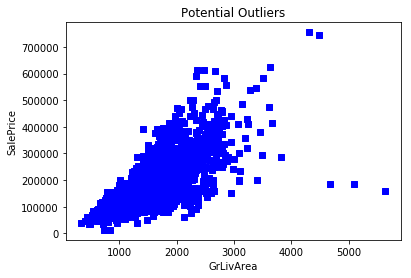

In [104]:
# Looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
plt.scatter(data["GrLivArea"], data["SalePrice"], c = "blue", marker = "s")
plt.title("Potential Outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

# get rid of outliers 
data = data[data.GrLivArea < 4000]

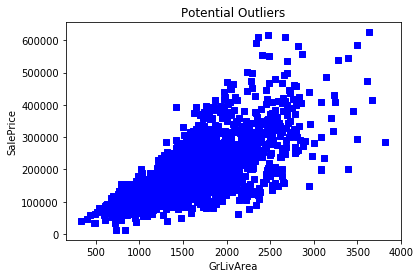

In [105]:
# Cleaned of outliers
plt.scatter(data["GrLivArea"], data["SalePrice"], c = "blue", marker = "s")
plt.title("Potential Outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

#### Looking at Missing Data

       Attribute  Missing %
26        PoolQC     99.624
25   MiscFeature     96.410
24         Alley     93.231
23         Fence     80.479
22   FireplaceQu     48.615
21   LotFrontage     16.752
20   GarageYrBlt      5.436
19    GarageCond      5.436
18    GarageQual      5.436
17  GarageFinish      5.436
16    GarageType      5.368
15  BsmtExposure      2.838
14  BsmtFinType2      2.769
13      BsmtCond      2.735
12      BsmtQual      2.735
11  BsmtFinType1      2.735
10    MasVnrType      0.786
9     MasVnrArea      0.786
8   BsmtHalfBath      0.068
7   BsmtFullBath      0.068
1     GarageArea      0.034
6     GarageCars      0.034
5     BsmtFinSF2      0.034
4     BsmtFinSF1      0.034
3      BsmtUnfSF      0.034
2    TotalBsmtSF      0.034
0     Electrical      0.034

Missing values in 27 columns


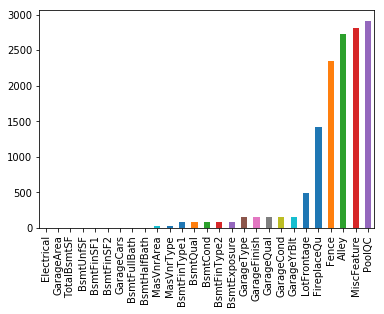

In [106]:
#missing attributes
missing = data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

missing_cols = {"Attribute": list(missing.index), 
                     "Missing %": [val / data.shape[0] * 100 for val in missing]}

missing_table = pd.DataFrame(data = missing_cols).sort_values(by="Missing %", ascending=False)

print(missing_table)
print("\nMissing values in " + str(len(missing_table)) + " columns")

In [107]:
data[missing.index].dtypes

Electrical       object
GarageArea      float64
TotalBsmtSF     float64
BsmtUnfSF       float64
BsmtFinSF1      float64
BsmtFinSF2      float64
GarageCars      float64
BsmtFullBath    float64
BsmtHalfBath    float64
MasVnrArea      float64
MasVnrType       object
BsmtFinType1     object
BsmtQual         object
BsmtCond         object
BsmtFinType2     object
BsmtExposure     object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
GarageYrBlt     float64
LotFrontage     float64
FireplaceQu      object
Fence            object
Alley            object
MiscFeature      object
PoolQC           object
dtype: object

## Preprocessing

#### Handle missing values - impute approach based on observations

In [108]:
# Filling NAs from missing_table top to bottom based on the descriptions from AmesHousing.txt
data.loc[:, "PoolQC"] = data.loc[:, "PoolQC"].fillna("None")
data.loc[:, "MiscFeature"] = data.loc[:, "MiscFeature"].fillna("None")
data.loc[:, "Alley"] = data.loc[:, "Alley"].fillna("NoAccess")
data.loc[:, "Fence"] = data.loc[:, "Fence"].fillna("None")
data.loc[:, "FireplaceQu"] = data.loc[:, "FireplaceQu"].fillna("None")
data.loc[:, "LotFrontage"] = data.loc[:, "LotFrontage"].fillna(0)

data.loc[:, "GarageYrBlt"] = data.loc[:, "GarageYrBlt"].fillna(0) # ordinal
data.loc[:, "GarageCond"] = data.loc[:, "GarageCond"].fillna("None")
data.loc[:, "GarageQual"] = data.loc[:, "GarageQual"].fillna("None")
data.loc[:, "GarageFinish"] = data.loc[:, "GarageFinish"].fillna("None")
data.loc[:, "GarageType"] = data.loc[:, "GarageType"].fillna("None")
data.loc[:, "GarageArea"] = data.loc[:, "GarageArea"].fillna(0)
data.loc[:, "GarageCars"] = data.loc[:, "GarageCars"].fillna(0)

data.loc[:, "BsmtExposure"] = data.loc[:, "BsmtExposure"].fillna("None")
data.loc[:, "BsmtFinType2"] = data.loc[:, "BsmtFinType2"].fillna("None")
data.loc[:, "BsmtQual"] = data.loc[:, "BsmtQual"].fillna("None")
data.loc[:, "BsmtCond"] = data.loc[:, "BsmtCond"].fillna("None")
data.loc[:, "BsmtFinType1"] = data.loc[:, "BsmtFinType1"].fillna("None")
data.loc[:, "BsmtFullBath"] = data.loc[:, "BsmtFullBath"].fillna(0)
data.loc[:, "BsmtHalfBath"] = data.loc[:, "BsmtHalfBath"].fillna(0)
data.loc[:, "BsmtFinSF1"] = data.loc[:, "BsmtFinSF1"].fillna(0)
data.loc[:, "BsmtFinSF2"] = data.loc[:, "BsmtFinSF2"].fillna(0)
data.loc[:, "BsmtUnfSF"] = data.loc[:, "BsmtUnfSF"].fillna(0)
data.loc[:, "TotalBsmtSF"] = data.loc[:, "TotalBsmtSF"].fillna(0)

data.loc[:, "MasVnrType"] = data.loc[:, "MasVnrType"].fillna("None")
data.loc[:, "MasVnrArea"] = data.loc[:, "MasVnrArea"].fillna(0)

data.loc[:, "Electrical"] = data.loc[:, "Electrical"].fillna("Mix")

#### Feature Engineering

In [109]:
#list(data.columns)

In [110]:
data["BsmtExposure"].unique()

array(['Gd', 'No', 'Mn', 'Av', 'None'], dtype=object)

In [111]:
# Simplify existing features and change various categorical features to ordinal features

#Month Sold - Season
data["SeasonSold"] = data["MoSold"].replace({12: "Winter", 1: "Winter", 2: "Winter",
                                            3: "Spring", 4: "Spring", 5: "Spring",
                                            6: "Summer", 7: "Summer", 8: "Summer",
                                            9: "Fall", 10: "Fall", 11: "Fall"})

#Overall Quality
data["SimpOverallQual"] = data["OverallQual"].replace({1: "Bad", 2: "Bad", 3: "Bad",
                                                      4: "Okay", 5: "Okay", 6: "Okay", 7: "Okay",
                                                       8: "Excellent", 9: "Excellent", 10: "Excellent",})

# Overall Cond
data["SimpOverallCond"] = data["OverallCond"].replace({1: "Bad", 2: "Bad", 3: "Bad",
                                                      4: "Okay", 5: "Okay", 6: "Okay", 7: "Okay",
                                                       8: "Excellent", 9: "Excellent", 10: "Excellent",})

# Simple External Quality - change to ordinal for combination feature
data["SimpExterQual"] = data["ExterQual"].replace({"Ex": 2, "Gd": 2,
                                                  "TA": 1, "Fa": 1,
                                                  "Po": 0})

# External Quality - change to ordinal for combination feature
data["ExterQual"] = data["ExterQual"].replace({"Ex": 5, "Gd": 4,
                                                  "TA": 3, "Fa": 2,
                                                  "Po": 1})

# Simple External Condition - change to ordinal for combination feature
data["SimpExterCond"] = data["ExterCond"].replace({"Ex": 2, "Gd": 2,
                                                  "TA": 1, "Fa": 1,
                                                  "Po": 0})

# External Condition - change to ordinal for combination feature
data["ExterCond"] = data["ExterCond"].replace({"Ex": 5, "Gd": 4,
                                                  "TA": 3, "Fa": 2,
                                                  "Po": 1})

# Simple Bsmt Quality - change to ordinal for combination feature
data["SimpBsmtQual"] = data["BsmtQual"].replace({"Ex": 3, "Gd": 3, # good
                                                  "TA": 1, "Fa": 1, # ok
                                                  "Po": 0, "None": 0}) # poor

# Bsmt Quality - change to ordinal for combination feature
data["BsmtQual"] = data["BsmtQual"].replace({"Ex": 5, "Gd": 4, # good
                                                  "TA": 3, "Fa": 2, # ok
                                                  "Po": 1, "None": 0}) # poor

# Simple Bsmt Cond - change to ordinal for combination feature
data["SimpBsmtCond"] = data["BsmtCond"].replace({"Ex": 3, "Gd": 3, # good
                                                  "TA": 1, "Fa": 1, # ok
                                                  "Po": 0, "None": 0}) # poor

# Bsmt Cond - change to ordinal for combination feature
data["BsmtCond"] = data["BsmtCond"].replace({"Ex": 5, "Gd": 4, # good
                                                  "TA": 3, "Fa": 2, # ok
                                                  "Po": 1, "None": 0}) # poor
# Bsmt Exposure
data["SimpBsmtExp"] = data["BsmtExposure"].replace({"Gd": "Good", "Av": "Good",
                                                  "Mn": "Poor", "No": "Poor"})
# BsmtFinType1
data["SimpBsmtFin1"] = data["BsmtFinType1"].replace({"GLQ": "Good", "ALQ": "Good",
                                                  "BLQ": "Ok", "Rec": "Ok",
                                                  "LwQ": "Poor", "Unf": "Poor"})
# BsmtFinType2
data["SimpBsmtFin2"] = data["BsmtFinType2"].replace({"GLQ": "Good", "ALQ": "Good",
                                                  "BLQ": "Ok", "Rec": "Ok",
                                                  "LwQ": "Poor", "Unf": "Poor", 
                                                     "None": "Poor"})
# HeatingQC
data["SimpHeatingQC"] = data["HeatingQC"].replace({"Ex": "Good", "Gd": "Good",
                                                  "TA": "Ok", "Fa": "Ok",
                                                  "Po": "Poor"})

# Simple KitchenQual - change to ordinal for combination feature
data["SimpKitchenQual"] = data["KitchenQual"].replace({"Ex": 2, "Gd": 2, # good
                                                  "TA": 1, "Fa": 1, # ok
                                                  "Po": 0}) # poor

# KitchenQual - change to ordinal for combination feature
data["KitchenQual"] = data["KitchenQual"].replace({"Ex": 5, "Gd": 4, # good
                                                  "TA": 3, "Fa": 2, # ok
                                                  "Po": 1}) # poor

# Functional
data["SimpFunctional"] = data["Functional"].replace({"Typ": "Minor", "Min1": "Minor", "Min2": "Minor", "Mod": "Minor",
                                                  "Maj1": "Major", "Maj2": "Major",
                                                  "Sev": "Severe", "Sal": "Severe"})

# FireplaceQu
data["SimpFireplaceQual"] = data["FireplaceQu"].replace({"Ex": "Good", "Gd": "Good",
                                                  "TA": "Ok", "Fa": "Ok",
                                                  "Po": "Poor", "None": "Poor"})
# Simple Garage Qual - change to ordinal for combination feature
data["SimpGarageQual"] = data["GarageQual"].replace({"Ex": 3, "Gd": 3, # good
                                                  "TA": 1, "Fa": 1, # ok
                                                  "Po": 0, "None": 0}) # poor

# Garage Qual - change to ordinal for combination feature
data["GarageQual"] = data["GarageQual"].replace({"Ex": 5, "Gd": 4, # good
                                                  "TA": 3, "Fa": 2, # ok
                                                  "Po": 1, "None": 0}) # poor

# Simple Garage Cond - change to ordinal for combination feature
data["SimpGarageCond"] = data["GarageCond"].replace({"Ex": 3, "Gd": 3, # good
                                                  "TA": 1, "Fa": 1, # ok
                                                  "Po": 0, "None": 0}) # poor

# Garage Cond - change to ordinal for combination feature
data["GarageCond"] = data["GarageCond"].replace({"Ex": 5, "Gd": 4, # good
                                                  "TA": 3, "Fa": 2, # ok
                                                  "Po": 1, "None": 0}) # poor

# Pool QC
data["SimpPoolQC"] = data["PoolQC"].replace({"Ex": "Good", "Gd": "Good",
                                                  "TA": "Ok", "Fa": "Ok"})
# Fence
data["SimpFence"] = data["Fence"].replace({"GdPrv": "Good", "GdWo": "Good",
                                                  "MnPrv": "Ok", "MnWw": "Ok"})

In [112]:
# Combinations of existing features

# Total Area
data["TotalArea"] = (data["OpenPorchSF"] + data["WoodDeckSF"] + data["GarageArea"] + data["EnclosedPorch"] +
                    data["LotArea"] + data["MasVnrArea"]  + data["TotalBsmtSF"]  + data["1stFlrSF"] +
                    data["2ndFlrSF"] + data["GrLivArea"])

data["HouseArea"] = (data["GarageArea"] + data["TotalBsmtSF"]  + data["1stFlrSF"] + 
                     data["2ndFlrSF"] + data["GrLivArea"])

data["FloorArea"] = data["1stFlrSF"] + data["2ndFlrSF"] + data["GrLivArea"]

# Overall Score: OverallQual * OverallCond
data["OverallScore"] = data["OverallQual"] * data["OverallCond"]

# External Score: ExterQual * ExterCond 
data["ExtScore"] = data["ExterQual"] * data["ExterCond"]

# Kitchen Score: KitchenQual * KitchenAbvGr
data["KitchScore"] = data["KitchenQual"] * data["KitchenAbvGr"]

# Basement Score: BsmtQual * BsmtCond
data["BsmtScore"] = data["BsmtQual"] * data["BsmtCond"]

# Garage Score: GarageQual * GarageCond
data["GarageScore"] = data["GarageQual"] * data["GarageCond"]

In [113]:
# Log transform the target for official scoring
data["SalePrice"] = np.log1p(data["SalePrice"])
y = data["SalePrice"]

# Diff numberical and categorical features
cat_feat = [x for x in data.columns if data.dtypes[x] == 'object']
num_feat = [x for x in data.columns if data.dtypes[x] != 'object']

# Find most important features relative to target
corr = data[num_feat].corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr["SalePrice"].head(10))

SalePrice     1.000
HouseArea     0.831
OverallQual   0.828
FloorArea     0.716
GrLivArea     0.711
ExterQual     0.687
GarageCars    0.675
KitchenQual   0.667
GarageArea    0.654
TotalBsmtSF   0.649
Name: SalePrice, dtype: float64


In [114]:
# Power transformations of existing features

# Squares
data["HouseArea2"] = data["HouseArea"] ** 2
data["OverallQual2"] = data["OverallQual"] ** 2
data["FloorArea2"] = data["FloorArea"] ** 2
data["GrLivArea2"] = data["GrLivArea"] ** 2
data["ExterQual2"] = data["ExterQual"] ** 2
data["KitchenQual2"] = data["KitchenQual"] ** 2
data["TotalBsmtSF2"] = data["TotalBsmtSF"] ** 2
data["GarageCars2"] = data["GarageCars"] ** 2
data["GarageArea2"] = data["GarageArea"] ** 2

# Square Root
data["HouseAreaSqrt"] = np.sqrt(data["HouseArea"])
data["OverallQualSqrt"] = np.sqrt(data["OverallQual"])
data["FloorAreaSqrt"] = np.sqrt(data["FloorArea"])
data["GrLivAreaSqrt"] = np.sqrt(data["GrLivArea"])
data["ExterQualSqrt"] = np.sqrt(data["ExterQual"])

# Cubes
data["HouseArea3"] = data["HouseArea"] ** 3
data["OverallQual3"] = data["OverallQual"] ** 3
data["FloorArea3"] = data["FloorArea"] ** 3
data["GrLivArea3"] = data["GrLivArea"] ** 3
data["ExterQual3"] = data["ExterQual"] ** 3

# log
data["HouseAreaLog"] = np.log1p(data["HouseArea"])
data["OverallQualLog"] = np.log1p(data["OverallQual"])
data["FloorAreaLog"] = np.log1p(data["FloorArea"])
data["GrLivAreaLog"] = np.log1p(data["GrLivArea"])
data["ExterQualLog"] = np.log1p(data["ExterQual"])

In [115]:
# Diff numberical and categorical features
cat_feat = [x for x in data.columns if data.dtypes[x] == 'object']
num_feat = [x for x in data.columns if data.dtypes[x] != 'object']
num_feat.remove('SalePrice')

data_cat = data[cat_feat]
data_num = data[num_feat] 

In [116]:
# Check for any null values within out dataset
data.isnull().values.sum()

0

In [117]:
# Create dummy features for categorical values via one-hot encoding
data_cat = pd.get_dummies(data_cat)

# Join the categorizal and numberic features
data = pd.concat([data_num, data_cat], axis=1)

In [118]:
# Do feature schaling on the numerical features
stdSc = StandardScaler()
data.loc[:, num_feat] = stdSc.fit_transform(data.loc[:, num_feat])
data.loc[:, num_feat] = stdSc.transform(data.loc[:, num_feat])

### Modeling

In [119]:
# Partition the dataset in train + test sets
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.2, random_state =0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (2340, 359)
X_test : (585, 359)
y_train : (2340,)
y_test : (585,)


In [120]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [121]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [101]:
# Look at predictions on training and validation set - this is without the sqrt and cube features.
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

RMSE on Training set : 0.12547344456676118
RMSE on Test set : 0.22073378052267278


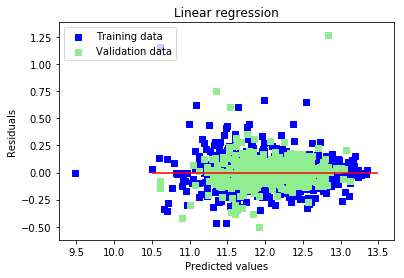

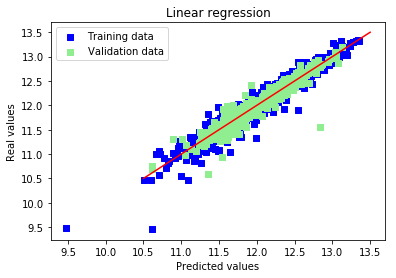

In [78]:
# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

Best alpha : 10.0
Try again for more precision with alphas centered around 10.0
Best alpha : 14.0
Ridge RMSE on Training set : 0.12059786033477175
Ridge RMSE on Test set : 0.11032117542115347


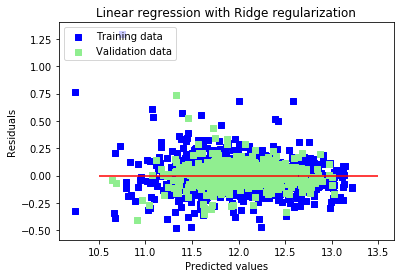

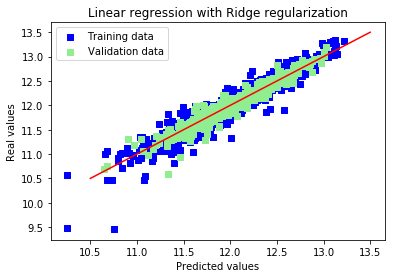

Ridge picked 359 features and eliminated the other 0 features


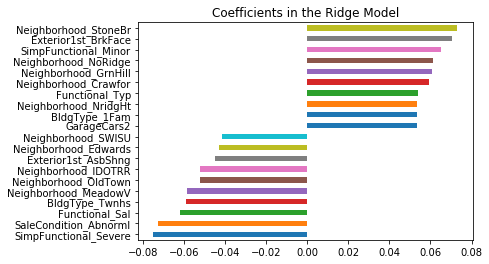

In [122]:
# 2* Ridge
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

Best alpha : 0.0003
Try again for more precision with alphas centered around 0.0003
Best alpha : 0.00025499999999999996
Lasso RMSE on Training set : 0.11965631652639563
Lasso RMSE on Test set : 0.1084481208106107


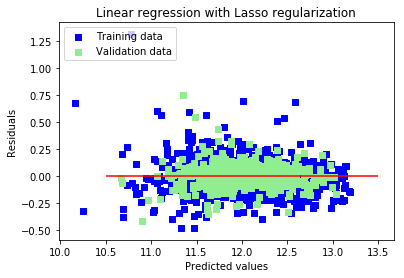

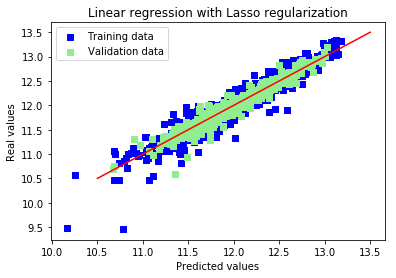

Lasso picked 139 features and eliminated the other 220 features


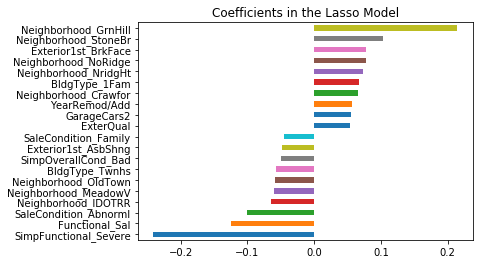

In [123]:
# 3* Lasso
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10, tol = 0.001)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10, tol = 0.001)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()